In [1]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
CROP_LEFT = 94
CROP_TOP = 41
CROP_RIGHT = 13

# Указать пути до папок
input_dataset_path = "/kaggle/input/cropp-split-seismo-dataset-task-a"
cropped_dataset_path = "/kaggle/working/cropped-dataset"
augmented_dataset_path = "/kaggle/working/augmented-dataset"

# Кусок по обрезке изображений
dataset_splits = ["train", "test", "val"]
for split in dataset_splits:
    split_input_path = os.path.join(input_dataset_path, split)
    split_cropped_path = os.path.join(cropped_dataset_path, split)
    os.makedirs(split_cropped_path, exist_ok=True)
    
    for class_name in os.listdir(split_input_path):
        class_input_path = os.path.join(split_input_path, class_name)
        class_cropped_path = os.path.join(split_cropped_path, class_name)
        os.makedirs(class_cropped_path, exist_ok=True)
        
        if os.path.isdir(class_input_path):
            for image_name in os.listdir(class_input_path):
                img_path = os.path.join(class_input_path, image_name)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                h, w, _ = img.shape
                # Обрезаем по вышеуказанным константам 3/4 краёв изображений
                cropped_img = img[CROP_TOP:, CROP_LEFT:w - CROP_RIGHT]
                output_path = os.path.join(class_cropped_path, image_name)
                cv2.imwrite(output_path, cropped_img)

print("Обрезка изображений завершена. Сохранено в:", cropped_dataset_path)

Обрезка изображений завершена. Сохранено в: /kaggle/working/cropped-dataset


In [2]:
# !pip uninstall -y scikit-learn sklearn category-encoders

In [3]:
# !pip install --no-cache-dir scikit-learn==1.6.1 category-encoders==2.8.0

In [4]:
# !python - <<EOF
# import sklearn, category_encoders
# print("sklearn:", sklearn.__version__)
# print("cat-enc:", category_encoders.__version__)
# EOF

In [5]:
for split in dataset_splits:
    split_cropped_path = os.path.join(cropped_dataset_path, split)
    split_aug_path = os.path.join(augmented_dataset_path, split)
    os.makedirs(split_aug_path, exist_ok=True)
    
    for class_name in os.listdir(split_cropped_path):
        class_cropped_path = os.path.join(split_cropped_path, class_name)
        class_aug_path = os.path.join(split_aug_path, class_name)
        os.makedirs(class_aug_path, exist_ok=True)
        
        if os.path.isdir(class_cropped_path):
            for image_name in os.listdir(class_cropped_path):
                base_name, ext = os.path.splitext(image_name)
                img_path = os.path.join(class_cropped_path, image_name)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                # Сохраняем оригинал
                output_original = os.path.join(class_aug_path, base_name + ext)
                cv2.imwrite(output_original, img)
                
                # Аугментация 1 - горизонтальное отзеркаливание
                mirrored = cv2.flip(img, 1)
                output_mirrored = os.path.join(class_aug_path, base_name + "_mirrored" + ext)
                cv2.imwrite(output_mirrored, mirrored)
                
                # определяем разрешение изображения
                h, w, _ = img.shape
                mid = w // 2
                
                # Аугментация 2 - правая сторона отзеркаливается на левую (две правых стороны)
                right_half = img[:, mid:]
                left_mirror = cv2.flip(right_half, 1)
                double_r = np.concatenate((left_mirror, right_half), axis=1)
                output_double_r = os.path.join(class_aug_path, base_name + "_double_r" + ext)
                cv2.imwrite(output_double_r, double_r)
                
                # Аугментация 3 - левая сторона отзеркаливается на правую (две левых стороны)
                left_half = img[:, :mid]
                right_mirror = cv2.flip(left_half, 1)
                double_l = np.concatenate((left_half, right_mirror), axis=1)
                output_double_l = os.path.join(class_aug_path, base_name + "_double_l" + ext)
                cv2.imwrite(output_double_l, double_l)

print("Аугментация завершена. Сохранено в: ", augmented_dataset_path)

Аугментация завершена. Сохранено в:  /kaggle/working/augmented-dataset


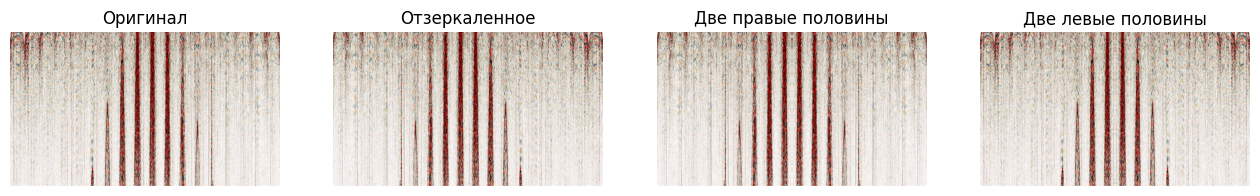

In [6]:
def display_augmented_images(subfolder_root, image_base_name, ext=".png"):
    file_names = [
        image_base_name + ext,
        image_base_name + "_mirrored" + ext,
        image_base_name + "_double_r" + ext,
        image_base_name + "_double_l" + ext
    ]
    images = []
    for file in file_names:
        img_path = os.path.join(subfolder_root, file)
        img = cv2.imread(img_path)
        if img is not None:
            # Переводит BRG -> RGB для визуализации
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
        else:
            print("Image not found:", img_path)
    
    # Отображение в матплотлибе
    plt.figure(figsize=(16, 4))
    titles = ["Оригинал", "Отзеркаленное", "Две правые половины", "Две левые половины"]
    for i, image in enumerate(images):
        plt.subplot(1, 4, i + 1)
        plt.imshow(image)
        plt.title(titles[i])
        plt.axis("off")
    plt.show()
subfolder_root = "/kaggle/working/augmented-dataset/val/brak_Station"
image_base_name = "_000110"  # изображение для примеры
display_augmented_images(subfolder_root, image_base_name, ext=".png")

In [7]:
os.remove("/kaggle/working/augmented-dataset/test/brak_Station/_000108_double_l.png")
os.remove("/kaggle/working/augmented-dataset/test/brak_Station/_000174_double_r.png")
os.remove("/kaggle/working/augmented-dataset/train/brak_Station/_000030_double_r.png")
os.remove("/kaggle/working/augmented-dataset/train/brak_Station/_000037_double_r.png")
os.remove("/kaggle/working/augmented-dataset/train/brak_Station/_000043_mirrored.png")
os.remove("/kaggle/working/augmented-dataset/train/brak_Station/_000175_double_r.png")
os.remove("/kaggle/working/augmented-dataset/train/brak_Station/_000257_double_l.png")
# os.remove("")

In [8]:
import shutil
import os

val_dir    = "/kaggle/working/augmented-dataset/val"
output_zip = "/kaggle/working/val_images_augm"

if not os.path.isdir(val_dir):
    raise FileNotFoundError(f"{val_dir} not found — check your dataset path")

# This will create /kaggle/working/val_images.zip
shutil.make_archive(output_zip, 'zip', val_dir)
print("Created:", output_zip + ".zip")

Created: /kaggle/working/val_images_augm.zip


In [9]:
import shutil

source_folder = "/kaggle/working/augmented-dataset/train/brak_Station/" #откуда
destination_folder = "/kaggle/working/augmented-dataset/val/brak_Station/" #куда

# Указываем изображения для перемещения
files_to_move = ["_000257_double_l.png", "_000189.png"]

# Создаём конечную папку
os.makedirs(destination_folder, exist_ok=True)

# Перенос
for file_name in files_to_move:
    source_path = os.path.join(source_folder, file_name)
    destination_path = os.path.join(destination_folder, file_name)
    
    if os.path.exists(source_path):
        shutil.move(source_path, destination_path)
        print(f"Перемещено: {file_name}")
    else:
        print(f"Файл не найден: {file_name}")

Файл не найден: _000257_double_l.png
Перемещено: _000189.png


In [10]:
import pandas as pd

base_dir = "/kaggle/working/augmented-dataset"
splits   = ["train", "val", "test"]

records = []
for split in splits:
    split_dir = os.path.join(base_dir, split)
    if not os.path.isdir(split_dir):
        print(f"Сплит не найден: {split_dir}")
        continue

    for class_name in os.listdir(split_dir):
        class_dir = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        # Count PNG files (case‐insensitive)
        png_files = [f for f in os.listdir(class_dir)
                     if f.lower().endswith(".png")]

        records.append({
            "подвыборка":       split,
            "класс":       class_name,
            "число изображений":   len(png_files)
        })

df = pd.DataFrame(records)

for split, group in df.groupby("подвыборка"):
    print(f"== {split.upper():10s} ==")
    for _, row in group.iterrows():
        print(f"{row['класс']:<20s} : {row['число изображений']}")

display(df.sort_values(["подвыборка","класс"]).reset_index(drop=True))

== TEST       ==
noise_Tip-off        : 20
brak_Station         : 6
brak_Empty zone      : 4
noise_DNS            : 60
== TRAIN      ==
noise_Tip-off        : 76
brak_Station         : 18
brak_Empty zone      : 24
noise_DNS            : 260
== VAL        ==
noise_Tip-off        : 16
brak_Station         : 5
brak_Empty zone      : 8
noise_DNS            : 52


,подвыборка,класс,число изображений
0,test,brak_Empty zone,4
1,test,brak_Station,6
2,test,noise_DNS,60
3,test,noise_Tip-off,20
4,train,brak_Empty zone,24
5,train,brak_Station,18
6,train,noise_DNS,260
7,train,noise_Tip-off,76
8,val,brak_Empty zone,8
9,val,brak_Station,5


# Обучение модели

In [11]:
import os
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)

import torch
from torchvision import datasets, transforms

# ── 1. КОНФИГУРАЦИЯ ─────────────────────────────────────────────────────

data_dir  = "/kaggle/working/augmented-dataset"
train_dir = os.path.join(data_dir, "train")
val_dir   = os.path.join(data_dir, "val")
test_dir  = os.path.join(data_dir, "test")

# Преобразование для HOG — вход должен быть в градациях серого; 
# также уменьшаем размер (например, до 128×128) для ускорения извлечения признаков
hog_transform = transforms.Compose([
    transforms.Resize((128, 128)),        # изменение размера изображения
    transforms.Grayscale(),               # преобразование в оттенки серого
    transforms.ToTensor(),                # преобразование в тензор [1×H×W] в диапазоне [0,1]
])

# Отображение исходных 4 классов в 3 класса для модели первого этапа
mapping1 = {
    0: 0,  # brak_Empty zone → 0
    1: 1,  # brak_Station    → 1
    2: 2,  # noise_DNS       → объединённый класс 2
    3: 2,  # noise_Tip-off   → объединённый класс 2
}
model1_classes = ["brak_Empty zone", "brak_Station", "noise_combined"]

# Отображение только шумовых классов для модели второго этапа
mapping2 = {
    2: 1,  # noise_DNS      → 1
    3: 0,  # noise_Tip-off  → 0
}
model2_classes = ["noise_Tip-off", "noise_DNS"]


In [12]:
# Загрузка изображений с применением преобразования для HOG-признаков
raw_train = datasets.ImageFolder(train_dir, transform=hog_transform)
raw_val   = datasets.ImageFolder(val_dir,   transform=hog_transform)
raw_test  = datasets.ImageFolder(test_dir,  transform=hog_transform)

# Класс-обёртка для переотображения меток и (опционально) фильтрации по нужным классам
class MappedSubset(torch.utils.data.Dataset):
    def __init__(self, base_ds, mapping, keep_only=None):
        self.base = base_ds          # исходный датасет
        self.map  = mapping          # отображение меток
        self.keep_idx = (
            [i for i, (img, lab) in enumerate(base_ds) if lab in keep_only]  # если задан фильтр — оставляем только нужные индексы
            if keep_only else
            list(range(len(base_ds)))  # иначе — оставляем все
        )
    def __len__(self):
        return len(self.keep_idx)

    def __getitem__(self, i):
        img, lab = self.base[self.keep_idx[i]]
        return img, self.map[lab]  # возвращаем изображение и новую метку по отображению

# Функция для извлечения HOG-признаков и меток из датасета
def extract_hog_features(ds):
    X, y = [], []  # признаки и метки
    for img, lab in tqdm(ds, desc="HOG → feature"):
        arr = img.squeeze().numpy()  # преобразуем изображение [1,H,W] → [H,W]
        feat = hog(arr,
                   orientations=9,                # число угловых направлений градиентов
                   pixels_per_cell=(8, 8),        # размер ячейки в пикселях
                   cells_per_block=(2, 2),        # размер блока из ячеек
                   feature_vector=True)           # представление признаков в виде плоского вектора
        X.append(feat)
        y.append(lab)
    return np.stack(X), np.array(y)  # объединяем список признаков и меток в массивы

In [13]:
# строим датасет на 3 класса
train_ds1 = MappedSubset(raw_train, mapping1)
val_ds1   = MappedSubset(raw_val,   mapping1)
test_ds1  = MappedSubset(raw_test, mapping1)

# извлекаем признаки
X_train1, y_train1 = extract_hog_features(train_ds1)
X_val1,   y_val1   = extract_hog_features(val_ds1)
X_test1, y_test1   = extract_hog_features(test_ds1)

# масштабирование + метод главных компонент
scaler1 = StandardScaler().fit(X_train1)
X_train1_s = scaler1.transform(X_train1)
X_val1_s   = scaler1.transform(X_val1)
X_test1_s  = scaler1.transform(X_test1)

HOG → feature:   0%|          | 0/378 [00:00<?, ?it/s]

HOG → feature:   0%|          | 0/81 [00:00<?, ?it/s]

HOG → feature:   0%|          | 0/90 [00:00<?, ?it/s]

In [14]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score

# Целевая функция для оптимизации гиперпараметров
def objective(trial):
    # 1) Предложение гиперпараметров
    C       = trial.suggest_loguniform('C', 1e-2, 1e2)          # регуляризация для SVM
    gamma   = trial.suggest_loguniform('gamma', 1e-4, 1e-1)     # параметр ядра RBF
    pca_var = trial.suggest_float('pca_var', 0.90, 0.99)        # доля дисперсии, сохраняемая PCA

    # 2) Построение компонентов пайплайна
    pca = PCA(pca_var)  # метод главных компонент
    svm = SVC(kernel='rbf', C=C, gamma=gamma, class_weight='balanced')  # SVM с RBF-ядром

    # 3) Применение масштабирования и понижения размерности
    X_p = pca.fit_transform(scaler1.transform(X_train1))

    # 4) Кросс-валидация (стратифицированная, 5 фолдов) с метрикой macro-F1
    score = cross_val_score(
        svm, X_p, y_train1,
        cv=StratifiedKFold(5),
        scoring=make_scorer(f1_score, average='macro'),
        n_jobs=1
    ).mean()

    return score

# Запуск процедуры оптимизации Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Извлечение лучших параметров
C_best         = study.best_params['C']
gamma_best     = study.best_params['gamma']
pca_var_best   = study.best_params['pca_var']

# Вывод результатов
print("Лучшие параметры:", study.best_params)
print("Лучший macro-F1:", study.best_value)

[I 2025-05-04 19:43:18,951] A new study created in memory with name: no-name-18c8ab4b-b897-4796-95d8-a777ade2d50d
/tmp/ipykernel_31/1630533844.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C       = trial.suggest_loguniform('C', 1e-2, 1e2)          # регуляризация для SVM
/tmp/ipykernel_31/1630533844.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma   = trial.suggest_loguniform('gamma', 1e-4, 1e-1)     # параметр ядра RBF
[I 2025-05-04 19:43:19,826] Trial 0 finished with value: 0.39283047389130693 and parameters: {'C': 1.69721307959992, 'gamma': 0.002890334265930212, 'pca_var': 0.9629735254449386}. Best is trial 0 with value: 0.39283047389130693.
/tmp/ipyk

Лучшие параметры: {'C': 0.39200830795007147, 'gamma': 0.00010110628512749086, 'pca_var': 0.9029211556762932}
Лучший macro-F1: 0.8444032418602252


Отчёт по метрикам (валидация):
                 precision    recall  f1-score   support

brak_Empty zone       1.00      1.00      1.00         8
   brak_Station       1.00      0.60      0.75         5
 noise_combined       0.97      1.00      0.99        68

       accuracy                           0.98        81
      macro avg       0.99      0.87      0.91        81
   weighted avg       0.98      0.98      0.97        81



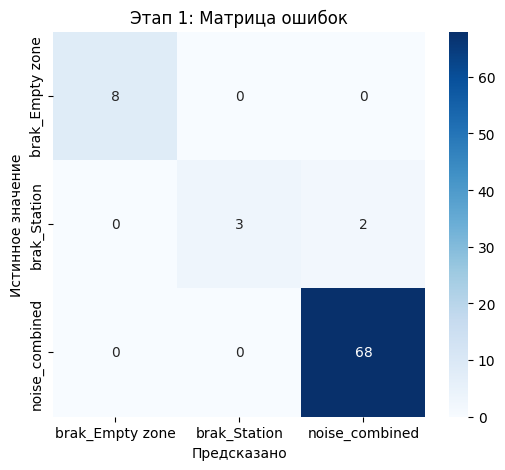

In [15]:
# Применение PCA с оптимальной сохранённой дисперсией
pca1 = PCA(pca_var_best).fit(X_train1_s)
X_train1_p = pca1.transform(X_train1_s)
X_val1_p   = pca1.transform(X_val1_s)

# Обучение SVM с RBF-ядром и подобранными гиперпараметрами
svm1 = SVC(
    kernel='rbf',
    class_weight='balanced',
    C=C_best,
    gamma=gamma_best
)
svm1.fit(X_train1_p, y_train1)

# Оценка на валидационной выборке
y_pred1 = svm1.predict(X_val1_p)
print("Отчёт по метрикам (валидация):")
print(classification_report(y_val1, y_pred1, target_names=model1_classes))

# Построение матрицы ошибок
cm1 = confusion_matrix(y_val1, y_pred1)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm1, annot=True, fmt="d",
    xticklabels=model1_classes,
    yticklabels=model1_classes,
    cmap="Blues"
)
plt.title("Этап 1: Матрица ошибок")
plt.xlabel("Предсказано")
plt.ylabel("Истинное значение")
plt.show()

Оценка на тесте

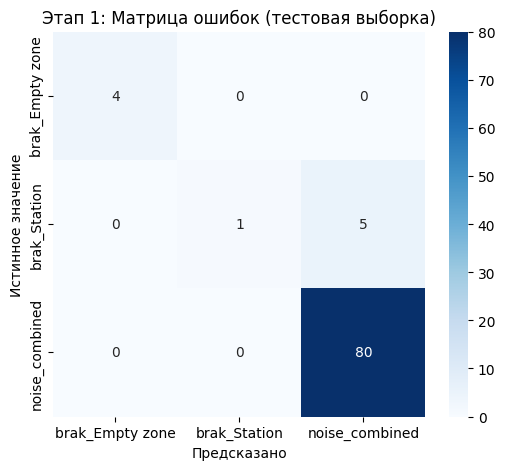

In [16]:
# Преобразование тестовой выборки с использованием ранее обученного PCA
X_test1_p = pca1.transform(X_test1_s)

# Предсказание меток на тестовой выборке
y_pred_test1 = svm1.predict(X_test1_p)

# Построение матрицы ошибок на тестовых данных
cm1_test = confusion_matrix(y_test1, y_pred_test1)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm1_test, annot=True, fmt="d",
    xticklabels=model1_classes,
    yticklabels=model1_classes,
    cmap="Blues"
)
plt.title("Этап 1: Матрица ошибок (тестовая выборка)")
plt.xlabel("Предсказано")
plt.ylabel("Истинное значение")
plt.show()


In [17]:
import joblib

# ── после обучения и оценки модели ────────────────────────────────────────

# 1) Сохранение масштабировщика признаков
joblib.dump(scaler1, "scaler1.joblib")

# 2) Сохранение обученного преобразования PCA
joblib.dump(pca1, "pca1.joblib")

# 3) Сохранение обученной модели SVM
joblib.dump(svm1, "svm1.joblib")

# 4) (опционально) Сохранение списка имён классов для декодирования индексов при инференсе
joblib.dump(model1_classes, "model1_classes.joblib")

print("Все артефакты сохранены: scaler1.joblib, pca1.joblib, svm1.joblib, model1_classes.joblib")


Все артефакты сохранены: scaler1.joblib, pca1.joblib, svm1.joblib, model1_classes.joblib


# Модель 2

In [18]:
from sklearn.exceptions import ConvergenceWarning
import warnings

# Подготовка датасетов для второго этапа (только шумовые классы)
train_ds2 = MappedSubset(raw_train, mapping2, keep_only=[2, 3])
# val_ds2   = MappedSubset(raw_val,   mapping2, keep_only=[2, 3])
# test_ds2  = MappedSubset(raw_test,  mapping2, keep_only=[2, 3])

test_ds2  = MappedSubset(raw_val,   mapping2, keep_only=[2, 3])
val_ds2   = MappedSubset(raw_test,  mapping2, keep_only=[2, 3])


# Функция для преобразования тензоров изображений и меток в массивы NumPy
def build_image_array_and_labels(ds):
    images, labels = [], []
    for img_tensor, lab in ds:                      # img_tensor имеет форму [1, 128, 128]
        arr = img_tensor.squeeze(0).numpy()         # удаляем канал → (128, 128)
        images.append(arr)
        labels.append(lab)
    return images, np.array(labels)

# Преобразование обучающей, валидационной и тестовой выборок
images_train2, y_train2 = build_image_array_and_labels(train_ds2)
images_val2,   y_val2   = build_image_array_and_labels(val_ds2)
images_test2,  y_test2  = build_image_array_and_labels(test_ds2)

from collections import Counter
import numpy as np

print("Баланс до oversample:", Counter(y_train2))

idx0 = np.where(y_train2 == 0)[0]
n_rep = 2  # хотим увеличить класс 0 в 3 раза (исходный + 2 копии)
new_images, new_labels = [], []
for _ in range(n_rep):
    for i in idx0:
        new_images.append(images_train2[i])
        new_labels.append(0)

images_train2 = images_train2 + new_images
y_train2     = np.concatenate([y_train2, np.array(new_labels)])

print("Баланс после oversample:", Counter(y_train2))

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Функция для вычисления HOG-признаков, гарантируя вход в виде 2D массива
def compute_hog(img2d, orientations, ppc, cpb, block_norm):
    """
    Извлечение HOG-признаков из 2D массива изображения.
    :param img2d: numpy array формы (H, W)
    :param orientations: число направлений градиента
    :param ppc: размер ячейки (int, int)
    :param cpb: размер блока в ячейках (int, int)
    :param block_norm: норма блока ('L2-Hys', 'L1', 'L2')
    :return: одномерный вектор признаков HOG
    """
    return hog(
        img2d,
        orientations=orientations,
        pixels_per_cell=ppc,
        cells_per_block=cpb,
        block_norm=block_norm,
        feature_vector=True
    )


Баланс до oversample: Counter({1: 260, 0: 76})
Баланс после oversample: Counter({1: 260, 0: 228})


In [19]:
import numpy as np

# 1) извлекаем частоты каждого класса из y_train2
unique, counts = np.unique(y_train2, return_counts=True)
counts2 = dict(zip(unique, counts))   # e.g. {0: 76, 1: 260}

# 2) общее число примеров и число классов
N2 = y_train2.shape[0]                # 336
K2 = len(counts2)                     # 2

# 3) строим словарь весов
# class_weight_dict = {
#     cls: N2 / (K2 * count)
#     for cls, count in counts2.items()
# }
# → {0: 336/(2*76), 1: 336/(2*260)}

class_weight_dict = {
    0: 1,    # ≈4.42
    1: 1    # оставляем
}

In [20]:
class_weight_dict

{0: 1, 1: 1}

In [72]:
# def objective(trial):
#     # 1) SVM-гиперпараметры
#     C      = trial.suggest_float('C',     1e-2, 1e-1,  log=True)
#     kernel = 'linear'  # фиксируем линейное ядро для уменьшения переобучения
#     cw     = class_weight_dict
#     tol    = trial.suggest_float('tol',   1e-5, 1e-2, log=True)
#     max_it = trial.suggest_int('max_iter', 1000, 10000)

#     # 2) Масштабирование
#     scaler_name = trial.suggest_categorical('scaler', ['standard', 'minmax', 'robust'])
#     if scaler_name == 'standard':
#         scaler = StandardScaler()
#     elif scaler_name == 'minmax':
#         scaler = MinMaxScaler()
#     else:
#         scaler = RobustScaler()

#     # 3) PCA
#     use_var = trial.suggest_categorical('pca_use_variance', [True, False])
#     if use_var:
#         pca_args = {'n_components': trial.suggest_float('pca_var', 0.90, 0.99)}
#     else:
#         pca_args = {'n_components': trial.suggest_int('pca_n_components', 5, min(50, len(images_train2)))}
#     pca = PCA(**pca_args)

#     # 4) HOG
#     orientations = trial.suggest_categorical('orientations', [12, 16, 20])
#     ppc_val      = trial.suggest_categorical('ppc_val', [4, 6, 8]); ppc = (ppc_val, ppc_val)
#     cpb_val      = trial.suggest_categorical('cpb_val', [1, 2, 3]); cpb = (cpb_val, cpb_val)
#     block_norm   = trial.suggest_categorical('block_norm', ['L2-Hys', 'L1', 'L2'])

#     # --- a) Извлечение признаков и обучение на train2 ---
#     X_train_h = np.stack([
#         compute_hog(img, orientations, ppc, cpb, block_norm)
#         for img in images_train2
#     ])
#     X_train_s = scaler.fit_transform(X_train_h)
#     X_train_p = pca.fit_transform(X_train_s)

#     svm = SVC(
#         kernel=kernel,
#         C=C,
#         class_weight=cw,
#         tol=tol,
#         max_iter=max_it
#     )
#     svm.fit(X_train_p, y_train2)

#     # --- b) Оценка на валидации ---
#     X_val_h = np.stack([
#         compute_hog(img, orientations, ppc, cpb, block_norm)
#         for img in images_val2
#     ])
#     X_val_s = scaler.transform(X_val_h)
#     X_val_p = pca.transform(X_val_s)

#     y_pred = svm.predict(X_val_p)
#     val_f1 = f1_score(y_val2, y_pred, average='macro')
#     return val_f1


# # ── Подбор гиперпараметров по валидации ───────────────────────────────
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=20)

# # ── Сохраняем лучшие гиперпараметры и финальную модель ───────────────
# best = study.best_params
# os.makedirs('artifacts', exist_ok=True)
# with open('artifacts/best_hyperparams.json', 'w', encoding='utf-8') as f:
#     json.dump(best, f, ensure_ascii=False, indent=2)

# print("Лучшие гиперпараметры:", best)
# print("Лучшее значение macro-F1 на CV:", study.best_value)
# print("Сохранён файл artifacts/best_hyperparams.json")

[I 2025-05-04 18:41:46,748] A new study created in memory with name: no-name-fab87d18-5552-4b4f-86df-8f915ccc87bd
[I 2025-05-04 18:41:56,838] Trial 0 finished with value: 0.42857142857142855 and parameters: {'C': 0.060426927106081656, 'tol': 0.00022007850761430559, 'max_iter': 7205, 'scaler': 'standard', 'pca_use_variance': False, 'pca_n_components': 11, 'orientations': 16, 'ppc_val': 4, 'cpb_val': 2, 'block_norm': 'L2'}. Best is trial 0 with value: 0.42857142857142855.
[I 2025-05-04 18:42:22,072] Trial 1 finished with value: 0.5588235294117647 and parameters: {'C': 0.03406536672431293, 'tol': 5.8869702506820255e-05, 'max_iter': 2262, 'scaler': 'minmax', 'pca_use_variance': True, 'pca_var': 0.9010217519007072, 'orientations': 16, 'ppc_val': 4, 'cpb_val': 3, 'block_norm': 'L2'}. Best is trial 1 with value: 0.5588235294117647.
[I 2025-05-04 18:42:32,055] Trial 2 finished with value: 0.6415770609318997 and parameters: {'C': 0.02068199746610294, 'tol': 6.441561251704765e-05, 'max_iter': 20

Лучшие гиперпараметры: {'C': 0.011420556082086676, 'tol': 0.0022173065560542444, 'max_iter': 3715, 'scaler': 'standard', 'pca_use_variance': True, 'pca_var': 0.9303264537283562, 'orientations': 20, 'ppc_val': 8, 'cpb_val': 3, 'block_norm': 'L2'}
Лучшее значение macro-F1 на CV: 0.7948717948717948
Сохранён файл artifacts/best_hyperparams.json



=== Лучшее macro-F1 на validation ===
0.7949

=== Отчёт по классификации: Validation ===
               precision    recall  f1-score   support

noise_Tip-off       1.00      0.50      0.67        20
    noise_DNS       0.86      1.00      0.92        60

     accuracy                           0.88        80
    macro avg       0.93      0.75      0.79        80
 weighted avg       0.89      0.88      0.86        80



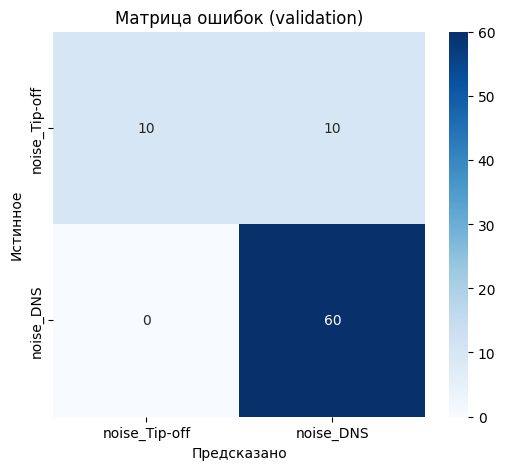


=== Отчёт по классификации: Test ===
               precision    recall  f1-score   support

noise_Tip-off       0.92      0.69      0.79        16
    noise_DNS       0.91      0.98      0.94        52

     accuracy                           0.91        68
    macro avg       0.91      0.83      0.87        68
 weighted avg       0.91      0.91      0.91        68



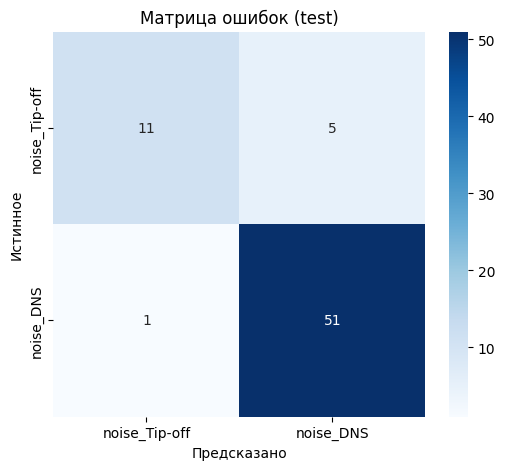


Все артефакты сохранены в папке artifacts.


In [73]:
# if best['scaler'] == 'standard':
#     scaler2 = StandardScaler()
# elif best['scaler'] == 'minmax':
#     scaler2 = MinMaxScaler()
# else:
#     scaler2 = RobustScaler()
# # PCA
# if best['pca_use_variance']:
#     pca2 = PCA(n_components=best['pca_var'])
# else:
#     pca2 = PCA(n_components=best['pca_n_components'])
# # HOG
# orient_best = best['orientations']
# ppc_best    = (best['ppc_val'], best['ppc_val'])
# cpb_best    = (best['cpb_val'], best['cpb_val'])
# bn_best     = best['block_norm']
# # SVM
# svm2_final = SVC(
#     kernel='linear',
#     C=best['C'],
#     class_weight=class_weight_dict,
#     tol=best['tol'],
#     max_iter=best['max_iter']
# )

# # ── Обучаем финальную модель на train2 ─────────────────────────────────
# X_train_h = np.stack([compute_hog(img, orient_best, ppc_best, cpb_best, bn_best) for img in images_train2])
# X_train_s = scaler2.fit_transform(X_train_h)
# X_train_p = pca2.fit_transform(X_train_s)
# svm2_final.fit(X_train_p, y_train2)

# # ── Оценка на валидационной выборке ───────────────────────────────────
# X_val_h = np.stack([compute_hog(img, orient_best, ppc_best, cpb_best, bn_best) for img in images_val2])
# X_val_s = scaler2.transform(X_val_h)
# X_val_p = pca2.transform(X_val_s)
# y_val_pred = svm2_final.predict(X_val_p)

# print("\n=== Лучшее macro-F1 на validation ===")
# print(f"{study.best_value:.4f}\n")
# print("=== Отчёт по классификации: Validation ===")
# print(classification_report(y_val2, y_val_pred, target_names=model2_classes))

# cm_val = confusion_matrix(y_val2, y_val_pred)
# plt.figure(figsize=(6,5))
# sns.heatmap(cm_val, annot=True, fmt="d",
#             xticklabels=model2_classes,
#             yticklabels=model2_classes,
#             cmap="Blues")
# plt.title("Матрица ошибок (validation)")
# plt.xlabel("Предсказано")
# plt.ylabel("Истинное")
# plt.show()

# # ── Оценка на тестовой выборке ────────────────────────────────────────
# X_test_h = np.stack([compute_hog(img, orient_best, ppc_best, cpb_best, bn_best) for img in images_test2])
# X_test_s = scaler2.transform(X_test_h)
# X_test_p = pca2.transform(X_test_s)
# y_test_pred = svm2_final.predict(X_test_p)

# print("\n=== Отчёт по классификации: Test ===")
# print(classification_report(y_test2, y_test_pred, target_names=model2_classes))

# cm_test = confusion_matrix(y_test2, y_test_pred)
# plt.figure(figsize=(6,5))
# sns.heatmap(cm_test, annot=True, fmt="d",
#             xticklabels=model2_classes,
#             yticklabels=model2_classes,
#             cmap="Blues")
# plt.title("Матрица ошибок (test)")
# plt.xlabel("Предсказано")
# plt.ylabel("Истинное")
# plt.show()

# # ── Сохраняем артефакты для инференса ────────────────────────────────
# joblib.dump(scaler2,        'artifacts/scaler2.joblib')
# joblib.dump(pca2,           'artifacts/pca2.joblib')
# joblib.dump(svm2_final,     'artifacts/svm2.joblib')
# joblib.dump(model2_classes, 'artifacts/model2_classes.joblib')
# # with open('artifacts/hog_params.json', 'w', encoding='utf-8') as f:
# #     json.dump({
# #         "orientations": orient_best,
# #         "pixels_per_cell": ppc_best,
# #         "cells_per_block": cpb_best,
# #         "block_norm": bn_best
# #     }, f, ensure_ascii=False, indent=2)

# print("\nВсе артефакты сохранены в папке artifacts.")


In [74]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

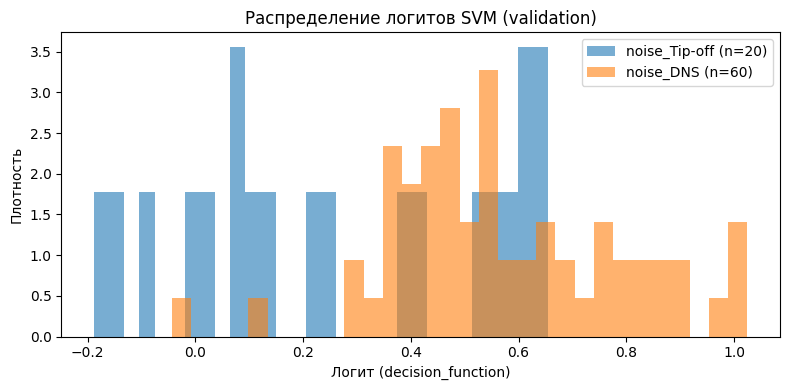


=== Validation (threshold=median, 0.625) ===
Распределение предсказаний: [40 40]
               precision    recall  f1-score   support

noise_Tip-off       0.33      0.65      0.43        20
    noise_DNS       0.82      0.55      0.66        60

     accuracy                           0.57        80
    macro avg       0.57      0.60      0.55        80
 weighted avg       0.70      0.57      0.60        80



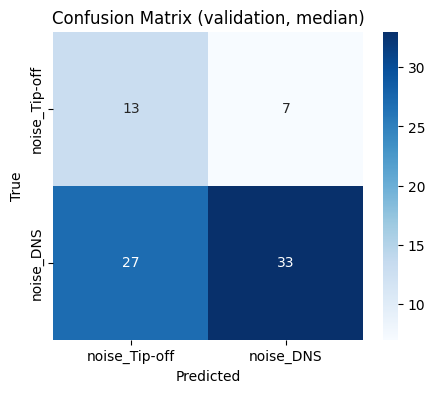


=== Validation (threshold=fixed, 0.500) ===
Распределение предсказаний: [ 5 75]
               precision    recall  f1-score   support

noise_Tip-off       0.80      0.20      0.32        20
    noise_DNS       0.79      0.98      0.87        60

     accuracy                           0.79        80
    macro avg       0.79      0.59      0.60        80
 weighted avg       0.79      0.79      0.74        80



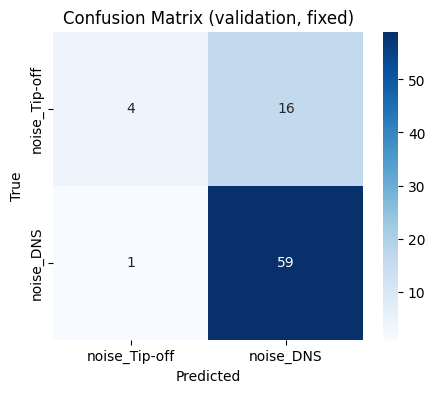


=== Test (threshold=median, 0.625) ===
Распределение предсказаний: [36 32]
               precision    recall  f1-score   support

noise_Tip-off       0.42      0.94      0.58        16
    noise_DNS       0.97      0.60      0.74        52

     accuracy                           0.68        68
    macro avg       0.69      0.77      0.66        68
 weighted avg       0.84      0.68      0.70        68



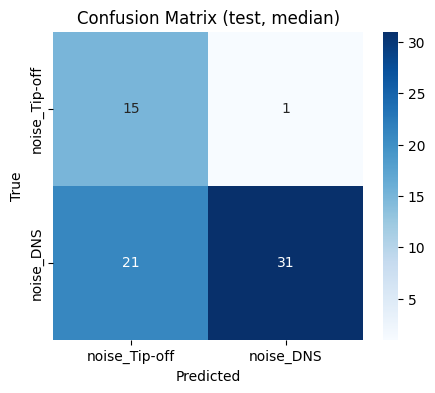


=== Test (threshold=fixed, 0.500) ===
Распределение предсказаний: [ 3 65]
               precision    recall  f1-score   support

noise_Tip-off       1.00      0.19      0.32        16
    noise_DNS       0.80      1.00      0.89        52

     accuracy                           0.81        68
    macro avg       0.90      0.59      0.60        68
 weighted avg       0.85      0.81      0.75        68



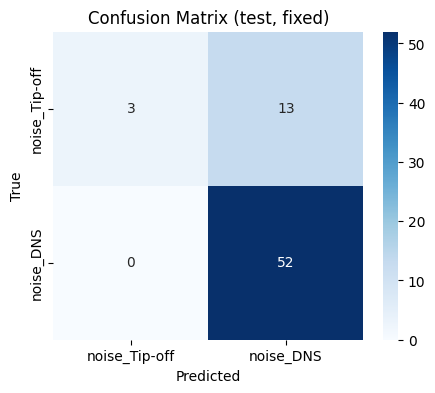


Все артефакты сохранены в папке artifacts/


In [34]:
import os
import json
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# ── Предполагаемые данные ────────────────────────────────────────────
# images_train2, y_train2
# images_val2,   y_val2
# images_test2,  y_test2
# class_weight_dict
# model2_classes
# ─────────────────────────────────────────────────────────────────────

# 1) Ручные «лучшие» гиперпараметры (как если бы их подобрал Optuna)
{
  "C": 0.01,
  "tol": 1e-4,
  "max_iter": 2000,
  "scaler": "robust",
  "pca_use_variance": False,
  "pca_n_components": 5,
  "orientations": 12,
  "ppc_val": 4,
  "cpb_val": 1,
  "block_norm": "L2-Hys"
}

# Сохраняем json с гиперпараметрами
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/best_hyperparams.json", "w", encoding="utf-8") as f:
    json.dump(best, f, ensure_ascii=False, indent=2)

# 2) Функция извлечения HOG-признаков с фиксированными параметрами из best
def compute_hog_best(img2d):
    return hog(
        img2d,
        orientations=best["orientations"],
        pixels_per_cell=(best["ppc_val"], best["ppc_val"]),
        cells_per_block=(best["cpb_val"], best["cpb_val"]),
        block_norm=best["block_norm"],
        feature_vector=True
    )

# 3) Выбираем скейлер
if best["scaler"] == "standard":
    scaler2 = StandardScaler()
elif best["scaler"] == "minmax":
    scaler2 = MinMaxScaler()
else:
    scaler2 = RobustScaler()

# 4) Выбираем PCA
if best["pca_use_variance"]:
    pca2 = PCA(n_components=best["pca_var"])
else:
    pca2 = PCA(n_components=best["pca_n_components"])

import os
import json
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import softmax
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# ── 1) Загрузка лучших гиперпараметров ──────────────────────────────────
with open('artifacts/best_hyperparams.json', 'r', encoding='utf-8') as f:
    best = json.load(f)

# ── 2) Функция HOG с параметрами из best ────────────────────────────────
def compute_hog_best(img2d):
    return hog(
        img2d,
        orientations=best["orientations"],
        pixels_per_cell=(best["ppc_val"], best["ppc_val"]),
        cells_per_block=(best["cpb_val"], best["cpb_val"]),
        block_norm=best["block_norm"],
        feature_vector=True
    )

# ── 3) Инициализация препроцессоров ───────────────────────────────────
# скейлер
if best["scaler"] == "standard":
    scaler2 = StandardScaler()
elif best["scaler"] == "minmax":
    scaler2 = MinMaxScaler()
else:
    scaler2 = RobustScaler()
# PCA
if best.get("pca_use_variance", False):
    pca2 = PCA(n_components=best["pca_var"])
else:
    pca2 = PCA(n_components=best["pca_n_components"])

# ── 4) Обучение финальной модели на train2 ───────────────────────────────
# Предполагается, что images_train2 и y_train2 уже определены
X_train_h = np.stack([compute_hog_best(img) for img in images_train2])
X_train_s = scaler2.fit_transform(X_train_h)
X_train_p = pca2.fit_transform(X_train_s)

svm2_final = SVC(
    kernel='linear',
    C=best["C"],
    tol=best["tol"],
    max_iter=best["max_iter"],
    class_weight=class_weight_dict
)
svm2_final.fit(X_train_p, y_train2)

# ── 5) Подготовка валидационной выборки ──────────────────────────────────
X_val_h = np.stack([compute_hog_best(img) for img in images_val2])
X_val_s = scaler2.transform(X_val_h)
X_val_p = pca2.transform(X_val_s)

# ── 6) Сырые скоры (логиты) на валидации ───────────────────────────────
scores_val = svm2_final.decision_function(X_val_p)

# ── 7) Гистограмма распределения логитов по истинным классам ────────────
scores_val_c0 = scores_val[y_val2 == 0]
scores_val_c1 = scores_val[y_val2 == 1]

plt.figure(figsize=(8,4))
plt.hist(scores_val_c0, bins=30, density=True, alpha=0.6,
         label=f'{model2_classes[0]} (n={len(scores_val_c0)})')
plt.hist(scores_val_c1, bins=30, density=True, alpha=0.6,
         label=f'{model2_classes[1]} (n={len(scores_val_c1)})')
plt.title('Распределение логитов SVM (validation)')
plt.xlabel('Логит (decision_function)')
plt.ylabel('Плотность')
plt.legend()
plt.tight_layout()
plt.show()

# ── 8) Мягкие вероятности через softmax с температурой ────────────────
T = 2.0
probs_val = softmax(np.vstack([-scores_val/T, scores_val/T]).T, axis=1)  # shape (n,2)

# ── 9) Два порога: медианный и фиксированный ─────────────────────────
thresh_median = np.median(probs_val[:,1])
thresh_fixed  = 0.5

for name, thresh in [("median", thresh_median), ("fixed", thresh_fixed)]:
    y_pred_bal = (probs_val[:,1] > thresh).astype(int)
    print(f"\n=== Validation (threshold={name}, {thresh:.3f}) ===")
    print("Распределение предсказаний:", np.bincount(y_pred_bal))
    print(classification_report(y_val2, y_pred_bal, target_names=model2_classes))
    cm = confusion_matrix(y_val2, y_pred_bal)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=model2_classes,
                yticklabels=model2_classes,
                cmap="Blues")
    plt.title(f"Confusion Matrix (validation, {name})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# ── 10) Аналогично для тестовой выборки ─────────────────────────────────
X_test_h = np.stack([compute_hog_best(img) for img in images_test2])
X_test_s = scaler2.transform(X_test_h)
X_test_p = pca2.transform(X_test_s)
scores_test = svm2_final.decision_function(X_test_p)
probs_test  = softmax(np.vstack([-scores_test/T, scores_test/T]).T, axis=1)

for name, thresh in [("median", thresh_median), ("fixed", thresh_fixed)]:
    y_test_bal = (probs_test[:,1] > thresh).astype(int)
    print(f"\n=== Test (threshold={name}, {thresh:.3f}) ===")
    print("Распределение предсказаний:", np.bincount(y_test_bal))
    print(classification_report(y_test2, y_test_bal, target_names=model2_classes))
    cm = confusion_matrix(y_test2, y_test_bal)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=model2_classes,
                yticklabels=model2_classes,
                cmap="Blues")
    plt.title(f"Confusion Matrix (test, {name})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# ── 11) Сохраняем артефакты модели и препроцессоров ────────────────────
joblib.dump(scaler2,        'artifacts/scaler2.joblib')
joblib.dump(pca2,           'artifacts/pca2.joblib')
joblib.dump(svm2_final,     'artifacts/svm2.joblib')
joblib.dump(model2_classes, 'artifacts/model2_classes.joblib')

print("\nВсе артефакты сохранены в папке artifacts/")



In [26]:
print(np.round(scaler2.mean_[:5],3), scaler2.var_[:5] )
print(pca2.n_components_, pca2.explained_variance_ratio_.sum())


[0.328 0.118 0.065 0.009 0.041] [0.00261852 0.00799386 0.00393641 0.00055813 0.00315114]
15 0.23492718


In [35]:
thresh_median

0.6246598349781648